In [1]:
from argparse import ArgumentParser
from functools import partial
import math
import time

import numpy as np
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from preprocessing import dataset
from preprocessing import vocabulary
from training import loss, mask, schedule
from training.model import transformer


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
arg_parser = ArgumentParser()
arg_parser.add_argument('--dict', required=True)
arg_parser.add_argument('--data', required=True)
arg_parser.add_argument('--split', type=int, default=5000)

arg_parser.add_argument('--num-paths', type=int, default=100)
arg_parser.add_argument('--num-tokens', type=int, default=10)
arg_parser.add_argument('--num-targets', type=int, default=10)

arg_parser.add_argument('--num-layers', type=int, default=2)
arg_parser.add_argument('--num-heads', type=int, default=4)
arg_parser.add_argument('--embedding-size', type=int, default=32)
arg_parser.add_argument('--dense-size', type=int, default=64)
arg_parser.add_argument('--dropout-rate', type=float, default=.2)

arg_parser.add_argument('--batch-size', type=int, default=128)
arg_parser.add_argument('--epochs', type=int, default=100)
arg_parser.add_argument('--seed', type=int, default=239)

_StoreAction(option_strings=['--seed'], dest='seed', nargs=None, const=None, default=239, type=<class 'int'>, choices=None, help=None, metavar=None)

In [3]:
args = arg_parser.parse_args(['--dict', '/tmp/py150/extracted.dict.c2s', '--data', '/code-embeddings/examples/examples.c2s'])

In [4]:
subtoken2count, path2count, target2count, max_contexts = vocabulary.load(args.dict)

idx2sub, sub2idx = vocabulary.to_encoder_decoder(subtoken2count, special_tokens=[vocabulary.PAD, vocabulary.UNK])
idx2path, path2idx = vocabulary.to_encoder_decoder(path2count, special_tokens=[vocabulary.PAD, vocabulary.UNK])
idx2tar, tar2idx = vocabulary.to_encoder_decoder(target2count, special_tokens=[vocabulary.PAD, vocabulary.UNK, vocabulary.SOS, vocabulary.EOS])

token_table = vocabulary.to_table(sub2idx, sub2idx[vocabulary.UNK])
path_table = vocabulary.to_table(path2idx, path2idx[vocabulary.UNK])
target_table = vocabulary.to_table(tar2idx, tar2idx[vocabulary.UNK])

In [5]:
dst = dataset.create(
    args.data,
    args.num_paths,
    args.num_tokens,
    args.num_targets,
    token_table,
    path_table,
    target_table
)

In [6]:
model = transformer.Transformer(
    args.num_paths,
    args.num_tokens,
    args.num_layers,
    args.num_heads,
    args.embedding_size,
    args.dense_size,
    len(idx2path),
    len(idx2sub),
    len(idx2tar),
    1000,
    args.dropout_rate
)

In [7]:
checkpoint_path = "../checkpoints/train"

ckpt = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

Latest checkpoint restored!


In [8]:
def evaluate(X):
    X = {k: tf.expand_dims(v, 0) for k,v in X.items()}
    y = tf.expand_dims([tar2idx[vocabulary.SOS]], 0)

    for i in range(10):
        enc_padding_mask, combined_mask, dec_padding_mask = mask.create_masks(X['path_input'], y)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(X, 
                                                 y,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tar2idx[vocabulary.EOS]:
            return tf.squeeze(y, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        y = tf.concat([y, predicted_id], axis=-1)

    return tf.squeeze(y, axis=0), attention_weights

In [28]:
features = []
results = []
weights = []

for X, y in dst:
    y_hat, weight = evaluate(X)
    features.append(X)
    results.append((y.numpy(), y_hat.numpy()))
    weights.append(weight)

In [41]:
features[1]

{'token_left_input': <tf.Tensor: shape=(100, 10), dtype=int32, numpy=
 array([[852,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [852,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [852,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [852,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 24,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 24,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 24,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 13,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 13,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [852,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 13,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 13,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [ 24,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  

In [37]:
results[1][1][1:]

array([ 11, 149, 584], dtype=int32)

In [14]:
import matplotlib.pylab as plt

In [43]:
splits = []

with open(args.data, 'r') as file:
    for line in file:
        splits.append(line.split(' '))

In [47]:
splits[1][1:]

['elements,NameParam|args|NameParam,value',
 'elements,NameParam|args|arguments|FunctionDef|body|For|NameStore,x',
 'elements,NameParam|args|arguments|FunctionDef|body|For|NameLoad,elements',
 'elements,NameParam|args|arguments|FunctionDef|body|Return|NameLoad,false',
 'value,NameParam|args|arguments|FunctionDef|body|For|NameStore,x',
 'value,NameParam|args|arguments|FunctionDef|body|For|NameLoad,elements',
 'value,NameParam|args|arguments|FunctionDef|body|Return|NameLoad,false',
 'x,NameStore|For|NameLoad,elements',
 'x,NameStore|For|body|Return|NameLoad,false',
 'elements,NameLoad|For|body|Return|NameLoad,false',
 'x,NameLoad|CompareEq|NameLoad,value',
 'x,NameLoad|CompareEq|If|body|Return|NameLoad,true',
 'value,NameLoad|CompareEq|If|body|Return|NameLoad,true\n']

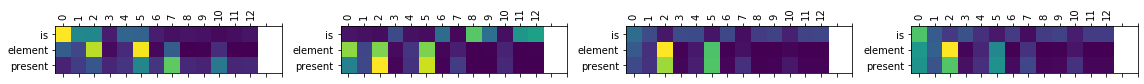

In [49]:
fig = plt.figure(figsize=(16, 8))

attention = tf.squeeze(weights[1]['decoder_layer2_block2'][:, :, :, :13], axis=0).numpy()
token_left = tf.squeeze(features[1]['token_left_input'][:13, :1], axis=1).numpy()
result = results[1][1][1:]

for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    ax.matshow(attention[head][:-1, :], cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(token_left) + 2))
    ax.set_yticks(range(len(result)))
    ax.set_ylim(len(result) - 0.5, -0.5)
    ax.set_xticklabels(list(range(len(token_left))), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([idx2tar[token] for token in result], fontdict=fontdict)

plt.tight_layout()
plt.show()

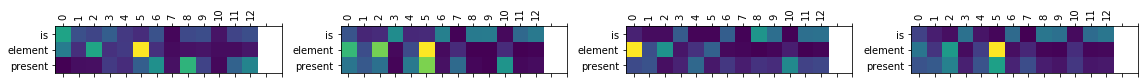

In [50]:
fig = plt.figure(figsize=(16, 8))

attention = tf.squeeze(weights[1]['decoder_layer1_block2'][:, :, :, :13], axis=0).numpy()
token_left = tf.squeeze(features[1]['token_left_input'][:13, :1], axis=1).numpy()
result = results[1][1][1:]

for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    ax.matshow(attention[head][:-1, :], cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(token_left) + 2))
    ax.set_yticks(range(len(result)))
    ax.set_ylim(len(result) - 0.5, -0.5)
    ax.set_xticklabels(list(range(len(token_left))), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([idx2tar[token] for token in result], fontdict=fontdict)

plt.tight_layout()
plt.show()